In [180]:
## Package management

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

pd.options.display.float_format = '{:,.6f}'.format
np.set_printoptions(suppress=True)

## SIS MODEL SIMULATION

In [181]:
def sis_model(G, gamma, beta, num_iterations, infected_percent):
    # Initialize the number of infected and susceptible nodes
    infected = set()
    susceptible = set(G.nodes())

    # Initialize the list of infected and susceptible nodes at each time step
    infected_list = []
    susceptible_list = []

    num_infected = int(len(G) * infected_percent)
    infected = set(random.sample(susceptible, num_infected))
    susceptible -= infected

    for t in range(num_iterations):
        # Compute the transition probabilities for each node
        for node in G.nodes():
            p_infect = len([n for n in G.neighbors(node) if n in infected]) * beta / G.degree(node)
            p_recover = gamma
            
            # Transition the node to the infected state with probability p_infect
            # or to the susceptible state with probability p_recover
            if node in infected:
                if random.random() < p_recover:
                    infected.remove(node)
                    susceptible.add(node)
            elif node in susceptible:
                if random.random() < p_infect:
                    infected.add(node)
                    susceptible.remove(node)
        
        # Append the number of infected and susceptible nodes to the list
        infected_list.append(len(infected))
        susceptible_list.append(len(susceptible))

    return infected_list, susceptible_list


## TASK 1  RESULTS

In [182]:
graphs_names = ["Complete","Scale-Free", "Small-World","Star","Regular Lattice","Erdos-Renyi"]
graphs = []
for name in graphs_names:
	if name == 'Complete':
		graphs.append(nx.complete_graph(1000))
	elif name == 'Scale-Free':
		graphs.append(nx.barabasi_albert_graph(1000, 3))
	elif name == 'Small-World':
		graphs.append(nx.watts_strogatz_graph(1000, 10, 0.5))
	elif name == 'Star':
		graphs.append(nx.star_graph(1000))
	elif name == 'Regular Lattice':
		graphs.append(nx.grid_graph(dim=[30, 30]))
	elif name == 'Erdos-Renyi':
		graphs.append(nx.erdos_renyi_graph(1000, 0.1))

In [183]:
def plot_sis_model(graphs_names,graphs, gamma, beta, num_iterations, infected_percent):
    
    for i, G in enumerate(graphs):
        # Simulate the spread of the disease on the current graph
        infected, susceptible = sis_model(G, gamma, beta, num_iterations, infected_percent)
        plt.figure()
        plt.plot(infected, label='Infected')
        plt.plot(susceptible, label='Susceptible')
        plt.title(f'SIS Model on {graphs_names[i]} Graph')
        plt.xlabel('Time step')
        plt.ylabel('Number of nodes')
        plt.legend()


/var/folders/n5/ktlz2xtn5vs65v3vw81n10k80000gn/T/ipykernel_33268/352020467.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected = set(random.sample(susceptible, num_infected))


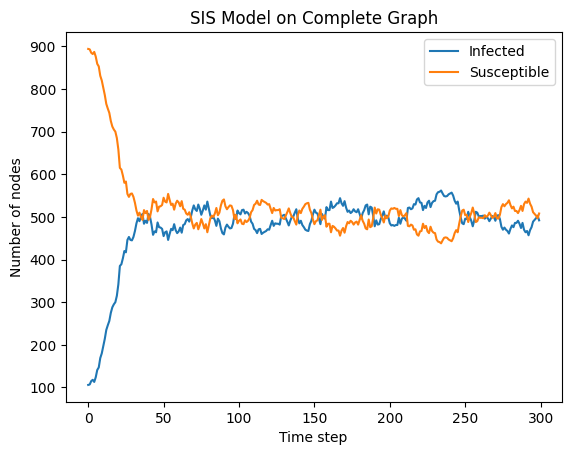

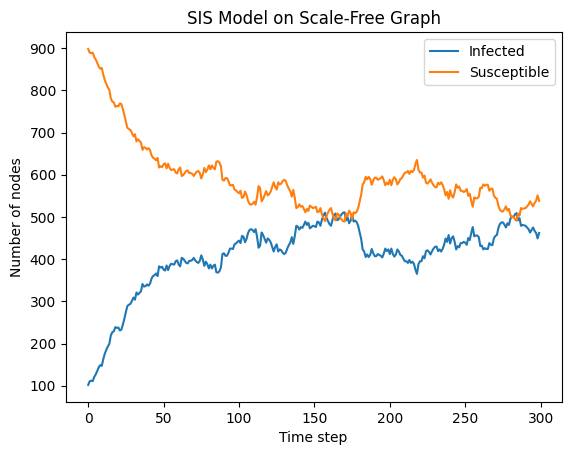

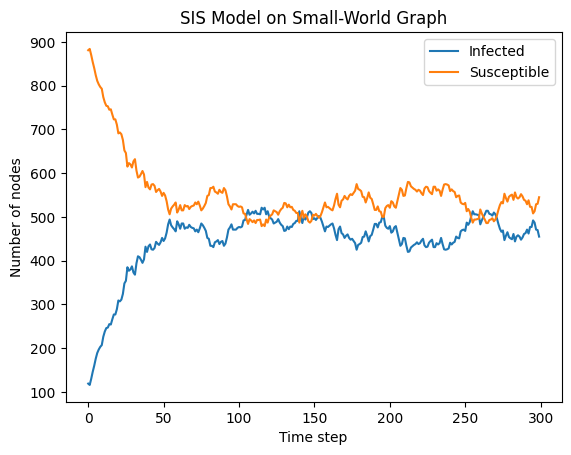

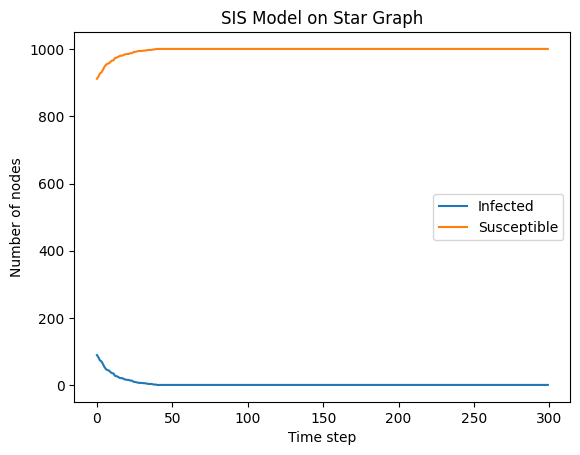

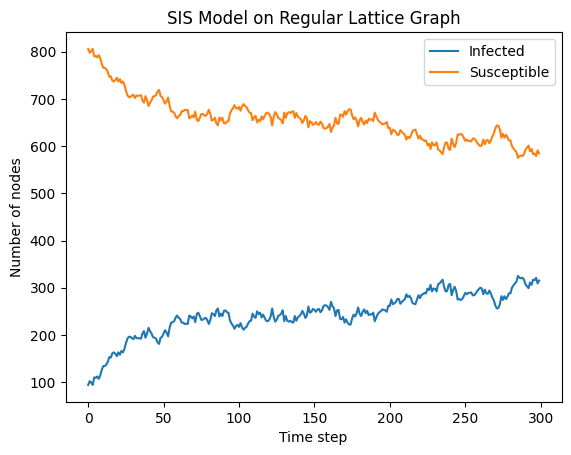

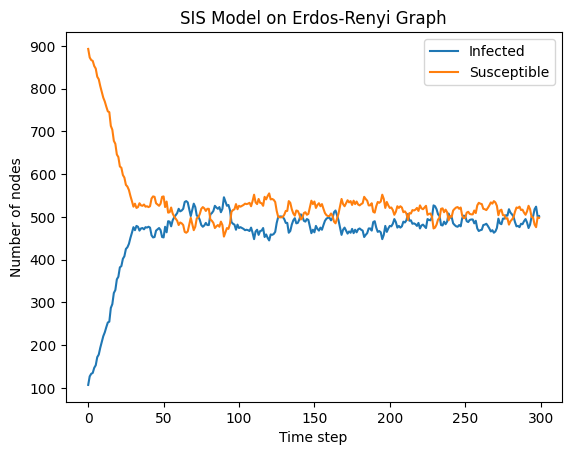

In [184]:
plot_sis_model(graphs_names, graphs, gamma=0.1, beta=0.2, num_iterations=300, infected_percent=0.1)

### TASK 2 

In [185]:
# get eigen values
import pandas as pd

def get_eigenvalues(graphs_names, graphs):
    rows = []
    for i, G in enumerate(graphs):
        eigenvalues = nx.linalg.adjacency_spectrum(G)
        max_eigenvalue = max(eigenvalues)
        row = {'Graph': graphs_names[i], 'Eigenvalues': eigenvalues, 'Max Eigenvalue': max_eigenvalue}
        rows.append(row)
    
    df = pd.DataFrame(rows, columns=['Graph', 'Eigenvalues', 'Max Eigenvalue'])
    return df

df = get_eigenvalues(graphs_names, graphs)



/usr/local/lib/python3.10/site-packages/networkx/linalg/spectrum.py:110: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return sp.linalg.eigvals(nx.adjacency_matrix(G, weight=weight).todense())


In [186]:
df

,Graph,Eigenvalues,Max Eigenvalue
0,Complete,"[(999.0000000000059+0j), (-0.9999999999998808+...",999.000000+0.000000j
1,Scale-Free,"[(14.538135240916858+0j), (-10.399346831404522...",14.538135+0.000000j
2,Small-World,"[(10.419886423017092+0j), (7.185155520761048+0...",10.419886+0.000000j
3,Star,"[(31.62277660168374+0j), (-31.622776601683732+...",31.622777+0.000000j
4,Regular Lattice,"[(3.97947729356758+0j), (3.918119765009967+0j)...",3.979477+0.000000j
5,Erdos-Renyi,"[(100.93073472735907+0j), (-19.234054687108976...",100.930735+0.000000j


## Get threshold


In [187]:
def find_threshold_beta(G, gamma):
    # Compute the maximum eigenvalue of the adjacency matrix
    max_eigenvalue = max(nx.linalg.adjacency_spectrum(G))
    # Compute the threshold
    beta = (1 - gamma) / max_eigenvalue
    return beta

/usr/local/lib/python3.10/site-packages/networkx/linalg/spectrum.py:110: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return sp.linalg.eigvals(nx.adjacency_matrix(G, weight=weight).todense())
/var/folders/n5/ktlz2xtn5vs65v3vw81n10k80000gn/T/ipykernel_33268/352020467.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected = set(random.sample(susceptible, num_infected))
/usr/local/lib/python3.10/site-packages/networkx/linalg/spectrum.py:110: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  return sp.linalg.eigvals(nx.adjacency_matrix(G, weight=weight).todense())
/var/folders/n5/ktlz2xtn5vs65v3vw81n10k80000gn/T/ipykernel_33268/352020467.py:11: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected = set(random.sample(susceptible, num_i

,Graph,gamma,beta_thresh,beta_above,beta_below
0,Complete,0.100000,0.000901+0.000000j,0.001081+0.000000j,0.000721+0.000000j
1,Scale-Free,0.100000,0.061906+0.000000j,0.074287+0.000000j,0.049525+0.000000j
2,Small-World,0.100000,0.086373+0.000000j,0.103648+0.000000j,0.069099+0.000000j
3,Star,0.100000,0.028460+0.000000j,0.034153+0.000000j,0.022768+0.000000j
4,Regular Lattice,0.100000,0.226160+0.000000j,0.271392+0.000000j,0.180928+0.000000j
5,Erdos-Renyi,0.100000,0.008917+0.000000j,0.010700+0.000000j,0.007134+0.000000j


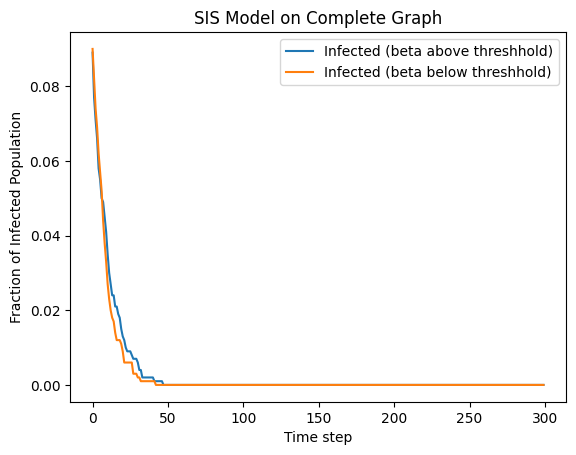

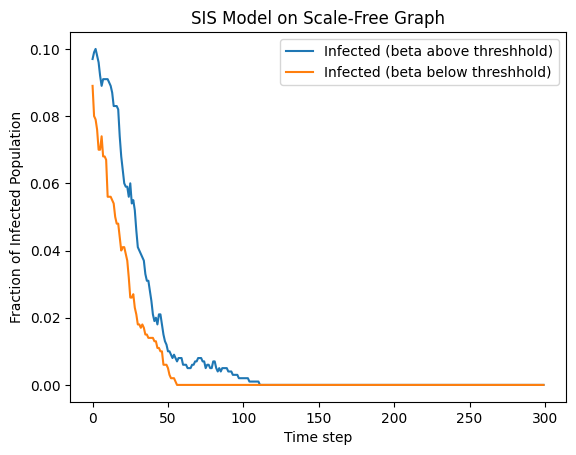

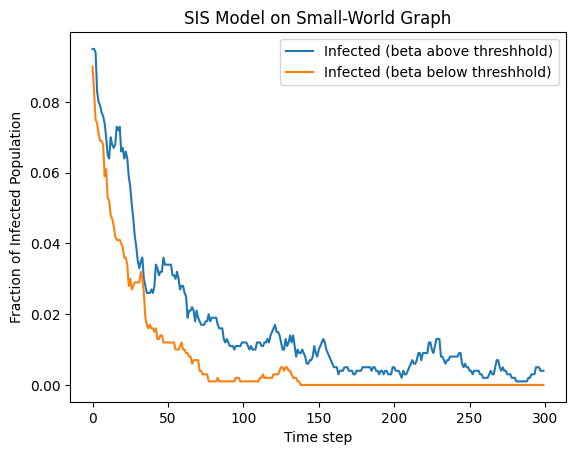

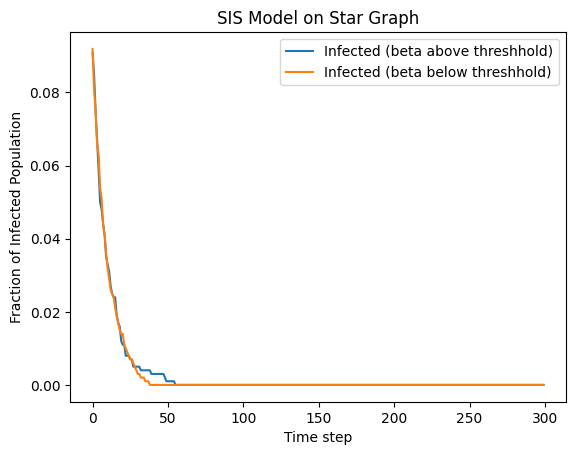

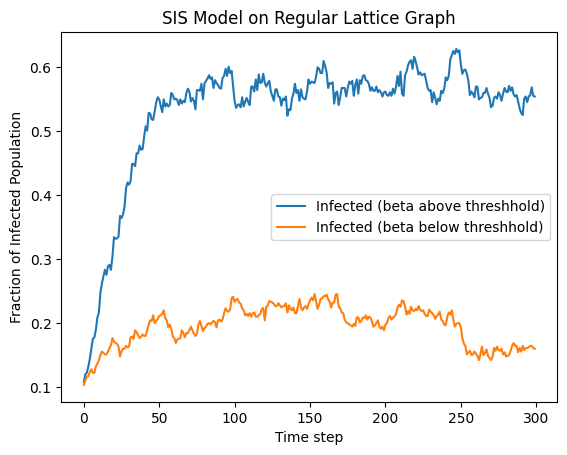

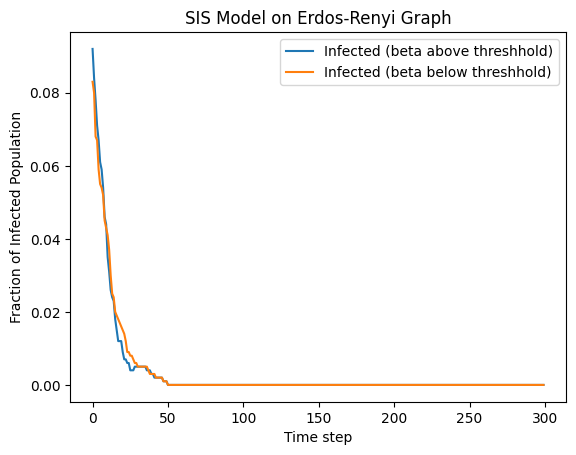

In [188]:
rows = []
for i, G in enumerate(graphs):
    
    df = pd.DataFrame(rows, columns=['Graph', 'Eigenvalues', 'Max Eigenvalue'])
    gamma = 0.1
    epsilon = 0.2
    # Compute the threshold
    beta_threshold = find_threshold_beta(G, gamma)
    beta_slightly_above = min(1,beta_threshold*(1+epsilon))
    beta_slightly_below = max(0,beta_threshold*(1-epsilon))
    # Simulate the SIS model with beta and gamma slightly above the threshold
    infected, susceptible = sis_model(G, gamma, beta_slightly_above, num_iterations=300, infected_percent=gamma)
	# Simulate the SIS model with beta and gamma slightly below the threshold
    infected2, susceptible2 = sis_model(G, gamma, beta_slightly_below, num_iterations=300, infected_percent=gamma)
    plt.figure()
    plt.plot([x/len(G) for x in infected], label='Infected (beta above threshhold)')
    plt.plot([x/len(G) for x in infected2], label='Infected (beta below threshhold)')
    plt.title(f'SIS Model on {graphs_names[i]} Graph')
    plt.xlabel('Time step')
    plt.ylabel('Fraction of Infected Population')
    plt.legend()
    
    row = {'Graph': graphs_names[i], 'gamma': gamma, 'beta_thresh': beta_threshold, 'beta_above': beta_slightly_above, 'beta_below': beta_slightly_below}
    rows.append(row)
 
df = pd.DataFrame(rows, columns=['Graph', 'gamma', 'beta_thresh','beta_above','beta_below'])
df